## Table of Contents

1. [Data Loading ](#data-loading)
2. [Data Preprocessing](#data-preprocessing)
    - [Removing Non english reviews](#rmv-non_english)
    - [Removing Stopwords](#rmv-stopwords)
3. [Data Splitting](#data-splitting)
4. [Topic Modelling](#topic-modelling)
    - [Without Seeding](#without-seeding)
    - [Seeding](#seeding)
4. [Feature Engineering](#feature)
5. [Visualization](#visual)
    - [Venn- Diagram of Discovered Topics](#venn)
    - [Histogram of the Topic words count](#hist)


In [2]:
# Standard Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re
import string
import csv

# Additional Libraries
from tqdm.auto import tqdm
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# Data Loading
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Load spaCy English language model
nlp = spacy.load("en_core_web_sm")



Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


______________________________________________________________________________________________________
# **Data Loading & Preprocessing**: <a name="data-loading"></a>
______________________________________________________________________________________________________


### Input data:


#### User Data
\[
\begin{matrix} user\_id  & property\_id &  review \end{matrix}
\]


In [3]:
review_dataset_path = "/content/drive/MyDrive/Colab Notebooks/research/main_data/filtered_english_review_extracted_from_airbnb_review_data.csv"
review_df = pd.read_csv(review_dataset_path,index_col=None)


In [4]:
review_df

,property_id,user_id,review
0,7202016,28943674,Cute and cozy place. Perfect location to every...
1,7202016,32440555,Kelly has a great room in a very central locat...
2,7202016,37722850,"Very spacious apartment, and in a great neighb..."
3,7202016,33671805,Close to Seattle Center and all it has to offe...
4,7202016,34959538,Kelly was a great host and very accommodating ...
...,...,...,...
83888,3624990,37578535,Comfortability upon arrival and everything wit...
83889,3624990,37419458,The description and pictures of the apartment ...
83890,3624990,6933252,We had an excellent stay. It was clean and com...
83891,3624990,24445024,"Very good apartement, clean and well sized. Si..."


In [5]:
# Obtaining value counts for each user_id
user_id_value_counts = review_df['user_id'].value_counts()

# Determining the maximum number of times a user_id is repeated
max_repeated_user = user_id_value_counts.max()
print("Maximum number a user_id is repeated:", max_repeated_user)

# Calculating the number of unique user_ids
num_unique_users = len(user_id_value_counts)
print("Number of unique user_ids:", num_unique_users)

# Counting the number of user_ids that appear only once
num_users_appear_once = (user_id_value_counts == 1).sum()
print("Number of user_ids that appear only once:", num_users_appear_once)



Maximum number a user_id is repeated: 67
Number of unique user_ids: 74853
Number of user_ids that appear only once: 68573



#### Property Data
\[
\begin{matrix} property\_id &  property\_description & ratings \end{matrix}
\]

In [6]:
property_dataset_path = "/content/drive/MyDrive/Colab Notebooks/research/main_data/description_property.csv"
property_df = pd.read_csv(property_dataset_path,index_col=None)


In [7]:
property_df

,property_id,description,ratings
0,241032,Make your self at home in this charming one-be...,95.0
1,953595,Chemically sensitive? We've removed the irrita...,96.0
2,3308979,New modern house built in 2013. Spectacular s...,97.0
3,7421966,A charming apartment that sits atop Queen Anne...,NaN
4,278830,Cozy family craftman house in beautiful neighb...,92.0
...,...,...,...
3813,8101950,Our 3BR/2BA house boasts incredible views of t...,80.0
3814,8902327,800 square foot 1 bedroom basement apartment w...,100.0
3815,10267360,"Very comfortable lower unit. Quiet, charming m...",NaN
3816,9604740,Cozy studio condo in the heart on Madison Park...,NaN


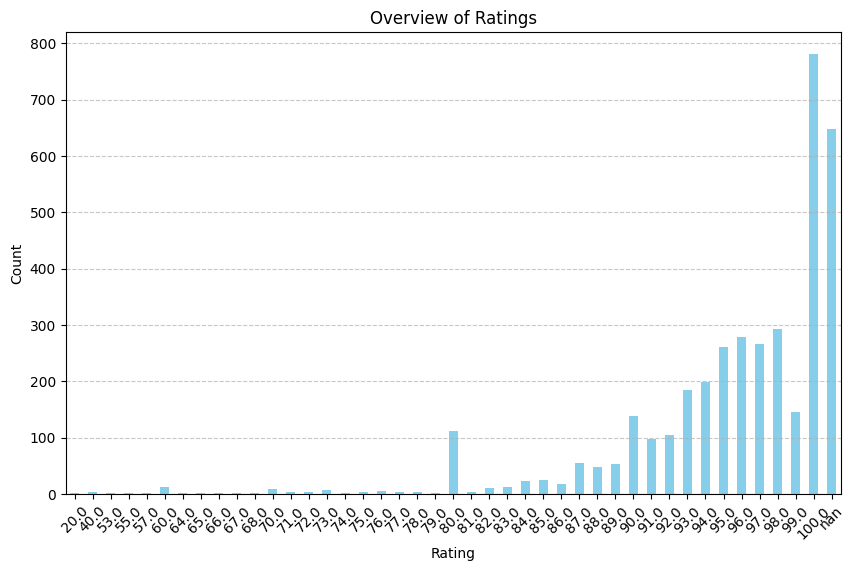

In [8]:
# visualizing the distribution of ratings
ratings_overview = property_df['ratings'].value_counts(dropna=False).sort_index()

plt.figure(figsize=(10, 6))
ratings_overview.plot(kind='bar', color='skyblue')
plt.title('Overview of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## **Data Preprocessing** <a name="data-preprocessing"></a>
______________________________________________________________________________________________________

In [9]:

# Initializing the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Dictionary for merging similar words for merging the split words
similar_word_mapping = {
    "wi": "wifi",
    "fi": "wifi"
}

def merge_similar_words(text):
    """
    Merge similar words based on a predefined mapping.

    Inputs:
        text (str): Input text.

    Returns:
        str: Text with similar words merged.
    """

    for similar_word, replacement in similar_word_mapping.items():
        # Using regular expression to match whole words only
        pattern = r'\b' + re.escape(similar_word) + r'\b'
        text = re.sub(pattern, replacement, text)

    return text


In [10]:

review_df['review'] = review_df['review'].apply(merge_similar_words)

property_df['description'] = property_df['description'].apply(merge_similar_words)

In [11]:
review_df.head()

,property_id,user_id,review
0,7202016,28943674,Cute and cozy place. Perfect location to every...
1,7202016,32440555,Kelly has a great room in a very central locat...
2,7202016,37722850,"Very spacious apartment, and in a great neighb..."
3,7202016,33671805,Close to Seattle Center and all it has to offe...
4,7202016,34959538,Kelly was a great host and very accommodating ...


In [12]:
property_df.head()

,property_id,description,ratings
0,241032,Make your self at home in this charming one-be...,95.0
1,953595,Chemically sensitive? We've removed the irrita...,96.0
2,3308979,New modern house built in 2013. Spectacular s...,97.0
3,7421966,A charming apartment that sits atop Queen Anne...,NaN
4,278830,Cozy family craftman house in beautiful neighb...,92.0


## **Data Splitting** <a name="data-splitting"></a>

______________________________________________________________________________________________________


In [13]:

from sklearn.model_selection import train_test_split

def split_dataset(data, train_size=0.7, test_size=0.2, eval_size=0.1, random_state=20):
    """
    Split a DataFrame into training, testing, and evaluation datasets.

    Inputs:
    - data: DataFrame, the input DataFrame to split.
    - train_size: float, optional (default=0.7), proportion of data to allocate for training.
    - test_size: float, optional (default=0.2), proportion of data to allocate for testing.
    - eval_size: float, optional (default=0.1), proportion of data to allocate for evaluation.
    - random_state: int, RandomState instance, or None, optional (default=None),
                    controls the shuffling of the data. Pass an int for reproducible output.

    Returns:
    - train_data: DataFrame, training dataset.
    - test_data: DataFrame, testing dataset.
    - eval_data: DataFrame, evaluation dataset.
    """
    # Spliting the data into training,test and valid
    train_data, temp_data = train_test_split(data, test_size=(1 - train_size), random_state=random_state)

    test_data, val_data = train_test_split(temp_data, test_size=(eval_size / (1 - train_size)), random_state=random_state)
    return train_data, test_data, val_data

# ======================================================================================================================
# ======================================================================================================================

def print_dataset_info(df, cols:list=[], dataset_type:str=""):
    """
    Displays Dataset information

    Inputs:
    - df: DataFrame
        The DataFrame for which information needs to be printed.
    - cols: list of str, optional
        The list of column names for which information needs to be displayed.
    - dataset_type: str, optional
        A string specifying the type of dataset (e.g., "Training", "Validation", etc.)
    """
    dataset_shape = df.shape

    print(f"{dataset_type} dataset size:\n\t\t({dataset_shape})" )

    if cols:
        for col in cols:
            if col in df.columns:
                if col in df.index.names:
                    unique_values = df.index.get_level_values(col).unique()
                else:
                    unique_values = df[col].unique()
                print(f"\nUnique values for '{col}':", len(unique_values))
            else:
                if col in df.index.names:
                    print(f"\nUnique values for '{col}':", df.index.get_level_values(col).nunique())
                else:
                    print(f"\n'{col}' column not found in the DataFrame.")





In [14]:
train_review, test_review, valid_review = split_dataset(review_df)


In [15]:
print_dataset_info(train_review, cols=['property_id', 'user_id'], dataset_type="Training")
train_review.head(5)

Training dataset size:
		((58725, 3))

Unique values for 'property_id': 3078

Unique values for 'user_id': 53817


,property_id,user_id,review
57437,6793490,9129697,Rob was very accommodating and accepted a book...
66422,1472532,10977089,Sid and Neha were awesome. They really helped ...
70343,3449059,27450730,I was in Seattle for business the week of Marc...
64370,2737012,10922774,We loved our time here. The studio was so cozy...
72621,3970736,31037410,Deborah made us feel very welcome and comforta...


In [16]:
print_dataset_info(valid_review, cols=['property_id', 'user_id'], dataset_type="Validation")
valid_review.head(5)

Validation dataset size:
		((8390, 3))

Unique values for 'property_id': 2052

Unique values for 'user_id': 8252


,property_id,user_id,review
64360,2737012,19136870,Immaculate and quiet with a VERY comfortable b...
49283,8027776,8631871,Thanks Marianne!! The apartment was the perfec...
56997,6127974,155626,The greenlake studio was very clean and well p...
21150,2763078,17639945,"The room was nice but for this price, I have s..."
72676,58503,3188802,"My experience with Visala, Dave and Maria was ..."


In [17]:
print_dataset_info(test_review, cols=['property_id', 'user_id'], dataset_type="Testing")
test_review.head(5)

Testing dataset size:
		((16778, 3))

Unique values for 'property_id': 2484

Unique values for 'user_id': 16283


,property_id,user_id,review
15871,6044106,27099102,We loved staying at Christine's place! The vie...
68489,3143227,5098623,Spring Street Center was the perfect place for...
83204,3968416,1168337,Another wonderful stay with Carolyn and Martin...
15663,113951,767996,Jill was wonderful. She called to make sure we...
75886,1432713,5295478,We had a great stay at Mr. Z's - the location ...


In [18]:
def preprocess_and_tokenize(review):
    """
    Preprocesses the input review by converting to lowercase,
    removing stopwords, punctuation, numbers, and lemmatizing.
    Additionally, tokenizes the input review into sentences and words.

    Inputs:
    - review (str): Input review to be preprocessed and tokenized.

    Returns:
    - tuple: Tuple containing lowercase review, preprocessed text,
             list of tokenized sentences, and list of tokenized words.
    """
    review_lowercase = review.lower()

    tokenized_sentences = [sentence.strip() for sentence in sent_tokenize(review_lowercase)]

    punctuation = set(string.punctuation)

    # Initializing filtered words list
    filtered_words = []

    # Tokenizing each sentence into words, removing punctuation and lemmatizing
    tokenized_sentence_words = []
    for sentence in tokenized_sentences:
        words = word_tokenize(sentence)
        lemmatized_words = []
        for word in words:
            # Remove punctuation
            if word not in punctuation:
                doc = nlp(word)
                for token in doc:
                    if token.is_alpha and not token.is_stop and token.pos_ != 'PUNCT' and token.pos_ != 'NUM' and (token.pos_ == 'VERB' or token.lemma_ != '-PRON-'):
                        if token.pos_ == 'VERB':
                            if token.lemma_ == 'be' and token.tag_ == 'VBP':
                                # Handling special case for 'is', 'are', 'am'
                                lemmatized_words.append('is')
                            elif token.lemma_ == 'do' and token.tag_ == 'VB':
                                # Handling special case for 'do', 'does'
                                lemmatized_words.append('do')
                            else:
                                lemmatized_words.append(token.lemma_)
                        else:
                            lemmatized_words.append(token.text)
        filtered_words.extend(lemmatized_words)

    # Joining lemmatized words into a single string
    preprocessed_text = ' '.join(filtered_words)

    # Tokenizing preprocessed text into words
    preprocessed_words = word_tokenize(preprocessed_text)

    return review_lowercase, preprocessed_text, tokenized_sentences, preprocessed_words



In [19]:

import ast

def apply_literal_ast_to_column(df, column):
    """
    Apply ast.literal_eval() to a DataFrame column to reatin the original data type from the saved drive file.

    Input:
    - df (DataFrame): DataFrame containing the column to apply literal_eval to.
    - column (str): Name of the column to apply literal_eval to.

    Returns:
    - None
    """
    df[column] = df[column].apply(ast.literal_eval)


In [20]:
main_data_path = "/content/drive/MyDrive/Colab Notebooks/research/main_data/"
train_review_path = "processed_train_review.csv"

# If the file exists, load the saved file
# If the file doesn't exist, preprocess and tokenize the review then save the dataframe for backup
if os.path.exists(os.path.join(main_data_path, train_review_path)):

    train_review = pd.read_csv(os.path.join(main_data_path, train_review_path))
    # Applying ast.literal_eval() to retain the orginal data which was saved as it was loaded as a string even for a list without ast
    apply_literal_ast_to_column(train_review, 'preprocessed_tokenized_word')
    apply_literal_ast_to_column(train_review, 'review_lemmatized_tokenized_sent')

else:

    train_review[['review', 'preprocessed_review', 'review_lemmatized_tokenized_sent', 'preprocessed_tokenized_word']] = train_review['review'].apply(preprocess_and_tokenize).apply(pd.Series)

    train_review.to_csv(os.path.join(main_data_path, train_review_path), index=False)


In [21]:
train_review

,property_id,user_id,review,preprocessed_review,review_lemmatized_tokenized_sent,preprocessed_tokenized_word
0,6793490,9129697,rob was very accommodating and accepted a book...,rob accommodate accept book minute helpful all...,[rob was very accommodating and accepted a boo...,"[rob, accommodate, accept, book, minute, helpf..."
1,1472532,10977089,sid and neha were awesome. they really helped ...,sid neha awesome help jam quick responsive go ...,"[sid and neha were awesome., they really helpe...","[sid, neha, awesome, help, jam, quick, respons..."
2,3449059,27450730,i was in seattle for business the week of marc...,seattle business week march time city want sta...,[i was in seattle for business the week of mar...,"[seattle, business, week, march, time, city, w..."
3,2737012,10922774,we loved our time here. the studio was so cozy...,love time studio cozy bed amazing sleep great ...,"[we loved our time here., the studio was so co...","[love, time, studio, cozy, bed, amazing, sleep..."
4,3970736,31037410,deborah made us feel very welcome and comforta...,deborah feel welcome comfortable apartment nic...,[deborah made us feel very welcome and comfort...,"[deborah, feel, welcome, comfortable, apartmen..."
...,...,...,...,...,...,...
58720,456040,2084798,we enjoyed our stay! it was easy to find ...,enjoy stay easy find close apartment roomy com...,"[we enjoyed our stay!, it was easy to find and...","[enjoy, stay, easy, find, close, apartment, ro..."
58721,7561333,254465,"jonathan was communicative and available, gave...",jonathan communicative available give perfect ...,"[jonathan was communicative and available, gav...","[jonathan, communicative, available, give, per..."
58722,7430926,7859809,audrey did a great job ensuring our stay was c...,audrey great job ensure stay comfortable accom...,[audrey did a great job ensuring our stay was ...,"[audrey, great, job, ensure, stay, comfortable..."
58723,1392332,20573874,we had a wonderful experience and loved our ti...,wonderful experience love time spend house ups...,[we had a wonderful experience and loved our t...,"[wonderful, experience, love, time, spend, hou..."


In [22]:
valid_review_path = "processed_eval_review.csv"


# If the file exists, load the saved file
# If the file doesn't exist, preprocess and tokenize the review then save the dataframe for backup
if os.path.exists(os.path.join(main_data_path, valid_review_path)):

    valid_review = pd.read_csv(os.path.join(main_data_path, valid_review_path))

    # Applying ast.literal_eval() to retain the orginal data which was saved as it was loaded as a string even for a list without ast
    apply_literal_ast_to_column(valid_review, 'preprocessed_tokenized_word')
    apply_literal_ast_to_column(valid_review, 'review_lemmatized_tokenized_sent')

else:
    valid_review[['review', 'preprocessed_review', 'review_lemmatized_tokenized_sent', 'preprocessed_tokenized_word']] = valid_review['review'].apply(preprocess_and_tokenize).apply(pd.Series)
    valid_review.to_csv(os.path.join(main_data_path, valid_review_path), index=False)

valid_review

,property_id,user_id,review,preprocessed_review,review_lemmatized_tokenized_sent,preprocessed_tokenized_word
0,2737012,19136870,immaculate and quiet with a very comfortable b...,immaculate quiet comfortable bed perfect,[immaculate and quiet with a very comfortable ...,"[immaculate, quiet, comfortable, bed, perfect]"
1,8027776,8631871,thanks marianne!! the apartment was the perfec...,thanks marianne apartment perfect spot girls w...,"[thanks marianne!!, the apartment was the perf...","[thanks, marianne, apartment, perfect, spot, g..."
2,6127974,155626,the greenlake studio was very clean and well p...,greenlake studio clean fixture floors feel con...,[the greenlake studio was very clean and well ...,"[greenlake, studio, clean, fixture, floors, fe..."
3,2763078,17639945,"the room was nice but for this price, i have s...",room nice price stay better places coffee room...,"[the room was nice but for this price, i have ...","[room, nice, price, stay, better, places, coff..."
4,58503,3188802,"my experience with visala, dave and maria was ...",experience visala dave maria fantastic chance ...,"[my experience with visala, dave and maria was...","[experience, visala, dave, maria, fantastic, c..."
...,...,...,...,...,...,...
8385,1758935,39176653,while we didn't see much of beth during our st...,beth stay feel welcome look room simple attrac...,[while we didn't see much of beth during our s...,"[beth, stay, feel, welcome, look, room, simple..."
8386,3333971,20956757,the suite was very quaint and in a fantastic a...,suite quaint fantastic area downtown seattle c...,[the suite was very quaint and in a fantastic ...,"[suite, quaint, fantastic, area, downtown, sea..."
8387,557126,23180352,"it's was very clean, it was like i expect and ...",clean like expect area pleasant cédric,"[it's was very clean, it was like i expect and...","[clean, like, expect, area, pleasant, cédric]"
8388,1562643,10433157,robert was great! the house had all the ameni...,robert great house amenities perfect location ...,"[robert was great!, the house had all the amen...","[robert, great, house, amenities, perfect, loc..."


In [23]:
valid_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8390 entries, 0 to 8389
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   property_id                       8390 non-null   int64 
 1   user_id                           8390 non-null   int64 
 2   review                            8390 non-null   object
 3   preprocessed_review               8388 non-null   object
 4   review_lemmatized_tokenized_sent  8390 non-null   object
 5   preprocessed_tokenized_word       8390 non-null   object
dtypes: int64(2), object(4)
memory usage: 393.4+ KB


In [24]:
test_review_path = "processed_test_review.csv"


# If the file exists, load the saved file
# If the file doesn't exist, preprocess and tokenize the review then save the dataframe for backup
if os.path.exists(os.path.join(main_data_path, test_review_path)):

    test_review = pd.read_csv(os.path.join(main_data_path, test_review_path))

    # Applying ast.literal_eval() to retain the orginal data which was saved as it was loaded as a string even for a list without ast
    apply_literal_ast_to_column(test_review, 'preprocessed_tokenized_word')
    apply_literal_ast_to_column(test_review, 'review_lemmatized_tokenized_sent')

else:

    test_review[['review', 'preprocessed_review', 'review_lemmatized_tokenized_sent', 'preprocessed_tokenized_word']] = test_review['review'].apply(preprocess_and_tokenize).apply(pd.Series)
    test_review.to_csv(os.path.join(main_data_path, test_review_path), index=False)

test_review

,property_id,user_id,review,preprocessed_review,review_lemmatized_tokenized_sent,preprocessed_tokenized_word
0,6044106,27099102,we loved staying at christine's place! the vie...,love stay christine place view phenomenal nice...,"[we loved staying at christine's place!, the v...","[love, stay, christine, place, view, phenomena..."
1,3143227,5098623,spring street center was the perfect place for...,spring street center perfect place stay seattl...,[spring street center was the perfect place fo...,"[spring, street, center, perfect, place, stay,..."
2,3968416,1168337,another wonderful stay with carolyn and martin...,wonderful stay carolyn martin,[another wonderful stay with carolyn and marti...,"[wonderful, stay, carolyn, martin]"
3,113951,767996,jill was wonderful. she called to make sure we...,jill wonderful call sure arrive ok sure need c...,"[jill was wonderful., she called to make sure ...","[jill, wonderful, call, sure, arrive, ok, sure..."
4,1432713,5295478,we had a great stay at mr. z's - the location ...,great stay mr z location residential capitol h...,[we had a great stay at mr. z's - the location...,"[great, stay, mr, z, location, residential, ca..."
...,...,...,...,...,...,...
16773,143580,5471216,jana's home was very close to a bus-stop that ...,jana home close bus stop take straight downtow...,[jana's home was very close to a bus-stop that...,"[jana, home, close, bus, stop, take, straight,..."
16774,5682,352959,"the place was great, it's very easily accessib...",place great easily accessible downtown clean h...,"[the place was great, it's very easily accessi...","[place, great, easily, accessible, downtown, c..."
16775,58503,28284877,terrific location and spacious place to stay. ...,terrific location spacious place stay hosts gr...,[terrific location and spacious place to stay....,"[terrific, location, spacious, place, stay, ho..."
16776,5020861,43454907,christen was a great host! the bed was comfort...,christen great host bed comfortable food coffe...,"[christen was a great host!, the bed was comfo...","[christen, great, host, bed, comfortable, food..."


In [25]:
property_description_path = "processed_property_df.csv"


# If the file exists, load the saved file
# If the file doesn't exist, preprocess and tokenize the review then save the dataframe for backup
if os.path.exists(os.path.join(main_data_path, property_description_path)):
    property_df = pd.read_csv(os.path.join(main_data_path, property_description_path))

    # Applying ast.literal_eval() to retain the orginal data which was saved as it was loaded as a string even for a list without ast
    apply_literal_ast_to_column(property_df, 'preprocessed_tokenized_word')
    apply_literal_ast_to_column(property_df, 'description_lemmatized_tokenized_sent')

else:
    property_df[['description','preprocessed_description','description_lemmatized_tokenized_sent','preprocessed_tokenized_word']] = property_df['description'].apply(preprocess_and_tokenize).apply(pd.Series)
    property_df.to_csv(os.path.join(main_data_path, property_description_path), index=False)

property_df

,property_id,description,ratings,preprocessed_description,description_lemmatized_tokenized_sent,preprocessed_tokenized_word
0,241032,make your self at home in this charming one-be...,95.0,self home charming bedroom apartment centrally...,[make your self at home in this charming one-b...,"[self, home, charming, bedroom, apartment, cen..."
1,953595,chemically sensitive? we've removed the irrita...,96.0,chemically sensitive ve remove irritants trigg...,"[chemically sensitive?, we've removed the irri...","[chemically, sensitive, ve, remove, irritants,..."
2,3308979,new modern house built in 2013. spectacular s...,97.0,new modern house build spectacular sunset wate...,[new modern house built in 2013. spectacular ...,"[new, modern, house, build, spectacular, sunse..."
3,7421966,a charming apartment that sits atop queen anne...,NaN,charming apartment sit atop queen anne hill no...,[a charming apartment that sits atop queen ann...,"[charming, apartment, sit, atop, queen, anne, ..."
4,278830,cozy family craftman house in beautiful neighb...,92.0,cozy family craftman house beautiful neighborh...,[cozy family craftman house in beautiful neigh...,"[cozy, family, craftman, house, beautiful, nei..."
...,...,...,...,...,...,...
3813,8101950,our 3br/2ba house boasts incredible views of t...,80.0,house boast incredible views olympic mountains...,[our 3br/2ba house boasts incredible views of ...,"[house, boast, incredible, views, olympic, mou..."
3814,8902327,800 square foot 1 bedroom basement apartment w...,100.0,square foot bedroom basement apartment fantast...,[800 square foot 1 bedroom basement apartment ...,"[square, foot, bedroom, basement, apartment, f..."
3815,10267360,"very comfortable lower unit. quiet, charming m...",NaN,comfortable lower unit quiet charming mid cent...,"[very comfortable lower unit., quiet, charming...","[comfortable, lower, unit, quiet, charming, mi..."
3816,9604740,cozy studio condo in the heart on madison park...,NaN,cozy studio condo heart madison park lake wa s...,[cozy studio condo in the heart on madison par...,"[cozy, studio, condo, heart, madison, park, la..."


#### Saving Processed Dataset For further processing

In [26]:
# main_data_path = "/content/drive/MyDrive/Colab Notebooks/research/main_data/"

# # Save property_df
# property_df.to_csv(os.path.join(main_data_path, "processed_property_df.csv"), index=False)

# # Save test_review
# test_review.to_csv(os.path.join(main_data_path, "processed_test_review.csv"), index=False)

# # Save eval_review
# eval_review.to_csv(os.path.join(main_data_path, "processed_eval_review.csv"), index=False)

# # Save train_review
# train_review.to_csv(os.path.join(main_data_path, "processed_train_review.csv"), index=False)

______________________________________________________________________________________________________
# **Topic Modelling** <a name="topic-modelling"></a>
______________________________________________________________________________________________________

## **LDA & NMF Class**
______________________________________________________________________________________________________

In [27]:
class TopicModel:
    """
    Class for performing topic modeling using NMF or LDA.
    """

    class TopicWordsSet:
        """
        Class to represent a set of topic words for each topic index.
        """
        def __init__(self):
            self.words = set()  # Initialize as a set

        def add_words(self, new_words):
            """
            Add new words to the set of topic words.

            Inputs:
                new_words (list): List of words to add to the set.
            """
            self.words.update(new_words)

    def __init__(self, model_type, no_topics, no_top_words, num_samples, no_features, sample_size, seed_words=None):
        """
        Initialize the TopicModel object.

        Inputs:
            model_type (str): Type of topic model to use ('NMF' or 'LDA').
            no_topics (int): Number of topics.
            no_top_words (int): Number of top words to display for each topic.
            num_samples (int): Number of samples to use for fitting the model.
            no_features (int): Number of features to use in the TF-IDF vectorizer.
            sample_size (int): Size of each sample to use for fitting the model.
            seed_words (list): Seed words for topic modeling (default is None).
        """
        self.model_type = model_type
        self.no_topics = no_topics
        self.no_top_words = no_top_words
        self.num_samples = num_samples
        self.no_features = no_features
        self.sample_size = sample_size
        self.seed_words = seed_words  # Seed words for topic modeling
        self.seed = 1  # Default seed for reproducibility

        if self.model_type == 'NMF':
            self.model = NMF(n_components=self.no_topics, random_state=self.seed, l1_ratio=.5, init='nndsvd')
        elif self.model_type == 'LDA':
            self.model = LatentDirichletAllocation(n_components=self.no_topics, max_iter=5, learning_method='online',
                                                    learning_offset=50., random_state=self.seed)
        else:
            raise ValueError("Invalid model_type. Choose 'NMF' or 'LDA'.")

        self.topic_words_list = []
        self.topic_words_dict = {idx: self.TopicWordsSet() for idx in range(self.no_topics)}  # Initialize TopicWordsSet objects
        self.coherence_scores = []
        self.tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=self.no_features, stop_words='english')

    def fit(self, data_df, text_column):
        """
        Fit the topic model to the data.

        Inputs:
            data_df (DataFrame): DataFrame containing the text data.
            text_column (str): Name of the column containing text data.
        """
        self._fit_model(data_df, text_column)


    def display_coherence_scores(self):
        """
        Display coherence scores for each sample.
        """
        print("Coherence Scores:")
        for idx, score in enumerate(self.coherence_scores):
            print(f"Sample {idx + 1}: {score}")


    def _fit_model(self, data_df, text_column):
      for sample_num in tqdm(range(self.num_samples), desc="Sampling Progress"):
          # Sample the DataFrame
          sampled_df = data_df.sample(n=self.sample_size, replace=False, random_state=sample_num)

          # Filter out rows with null preprocessed reviews
          sampled_df = sampled_df.dropna(subset=['preprocessed_review'])

          if not sampled_df.empty:
              # Vectorize text
              tfidf = self.tfidf_vectorizer.fit_transform(sampled_df[text_column])
              tfidf_feature_names = list(self.tfidf_vectorizer.get_feature_names_out())  # Convert to list

              # Add seed words to the vocabulary
              if self.seed_words:
                  tfidf_feature_names.extend(self.seed_words)

              # Update model
              self.model.fit(tfidf)
              topic_words = self._get_topic_words(tfidf_feature_names)
              self.topic_words_list.append(topic_words)

              # Compute coherence scores
              sampled_df_document = sampled_df[text_column].tolist()
              vocab_dict = Dictionary(sampled_df['preprocessed_tokenized_word'].tolist())
              coherence_model = CoherenceModel(topics=topic_words, texts=sampled_df_document,
                                              dictionary=vocab_dict, coherence='c_v', window_size=10)
              self.coherence_scores.append(coherence_model.get_coherence())

              # Update dictionaries with lists of topic words
              self._update_topic_words_dict(topic_words)


    def _get_topic_words(self, feature_names):
        """
        Get the top words for each topic.

        Inputs:
            feature_names (list): List of feature names.

        Returns:
            list: List of lists containing the top words for each topic.
        """
        topic_words = []
        for topic_idx, topic in enumerate(self.model.components_):
            topic_word_indices = topic.argsort()[:-self.no_top_words - 1:-1]
            topic_words.append([feature_names[i] for i in topic_word_indices])
        return topic_words

    def _update_topic_words_dict(self, topic_words_list):
        """
        Update the topic words dictionary with lists of topic words.

        Inputs:
            topic_words_list (list): List of lists containing topic words.
        """
        for idx, words_set in enumerate(topic_words_list):
            self.topic_words_dict[idx].add_words(words_set)

    def calculate_perplexity(self, test_data):
        """
        Calculate the perplexity of the model using test data.

        Inputs:
            test_data (array-like): Test data.

        Returns:
            float: Perplexity of the model.
        """
        tfidf_test = self.tfidf_vectorizer.transform(test_data)
        log_likelihood = self.model.score(tfidf_test)
        num_tokens = tfidf_test.sum()
        perplexity = np.exp(-log_likelihood / num_tokens)
        return perplexity

    def predict_topic_words(self, test_data_df, text_column='preprocessed_review'):
        """
        Predict topic words for the given test data using the trained model.

        Inputs:
            test_data_df (DataFrame): Test data DataFrame.
            text_column (str): Name of the column containing text data.

        Returns:
            list: List of lists containing the top words for each predicted topic.
        """
        # Remove empty rows from the specified text column
        test_data_df = test_data_df.dropna(subset=[text_column])

        if test_data_df.empty:
            print("Warning: Test data is empty after removing empty rows.")
            return []

        # Vectorize test data
        tfidf_test = self.tfidf_vectorizer.transform(test_data_df[text_column])

        # Predict topics for test data
        predicted_topics = self.model.transform(tfidf_test)

        # Get the top words for each topic
        if self.model_type == 'NMF' or self.model_type == 'LDA':
            feature_names = self.tfidf_vectorizer.get_feature_names_out()
        else:
            raise ValueError("Invalid model_type. Choose 'NMF' or 'LDA'.")

        topic_words_list = []
        for topic_distribution in self.model.components_:
            # Get indices of top words for the current topic
            top_word_indices = topic_distribution.argsort()[:-self.no_top_words - 1:-1]

            # Get the actual words from the feature names
            topic_words = [feature_names[i] for i in top_word_indices]
            topic_words_list.append(topic_words)

        return topic_words_list



    def display_topics(self):
        """
        Display the top words for each topic.
        """
        num_topics = min(len(self.topic_words_dict), self.no_topics)
        for i in range(num_topics):
            print(f"Topic {i}: {' '.join(self.topic_words_dict[i].words)}")
            print()

    @staticmethod
    def display_topics_loop(nmf_topic_words_list, lda_topic_words_list):
        """
        Display the top words for each topic in NMF and LDA models.

        Inputs:
            nmf_topic_words_list (list): List of lists containing top words for each topic in NMF.
            lda_topic_words_list (list): List of lists containing top words for each topic in LDA.
        """
        num_topics = min(len(nmf_topic_words_list[0]), len(lda_topic_words_list[0]))

        for i in range(num_topics):
            nmf_topic_words = [", ".join(topic[i]) for topic in nmf_topic_words_list]
            lda_topic_words = [", ".join(topic[i]) for topic in lda_topic_words_list]

            nmf_topic_string = "; ".join([f"loop{idx + 1}: [{words}]" for idx, words in enumerate(nmf_topic_words)])
            lda_topic_string = "; ".join([f"loop{idx + 1}: [{words}]" for idx, words in enumerate(lda_topic_words)])

            print(f"Nmf topic {i}: {nmf_topic_string}")
            print(f"LDA  topic {i}: {lda_topic_string}")
            print()


In [28]:
def display_topics_predicted(nmf_topic_words_list, lda_topic_words_list):
    """
    Display the top words for each topic in NMF and LDA models.

    Inputs:
        nmf_topic_words_list (list): List of lists containing top words for each topic in NMF.
        lda_topic_words_list (list): List of lists containing top words for each topic in LDA.
    """
    num_topics = min(len(nmf_topic_words_list), len(lda_topic_words_list))

    for i in range(num_topics):
        print(f"Nmf topic {i}: {' '.join(nmf_topic_words_list[i])}")
        print(f"LDA  topic {i}: {' '.join(lda_topic_words_list[i])}")
        print()



## **LDA & NMF Class Topic Modelling without seeds**
______________________________________________________________________________________________________

In [29]:
train_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58725 entries, 0 to 58724
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   property_id                       58725 non-null  int64 
 1   user_id                           58725 non-null  int64 
 2   review                            58725 non-null  object
 3   preprocessed_review               58710 non-null  object
 4   review_lemmatized_tokenized_sent  58725 non-null  object
 5   preprocessed_tokenized_word       58725 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


In [30]:
train_review[train_review['preprocessed_review'].isnull()]

,property_id,user_id,review,preprocessed_review,review_lemmatized_tokenized_sent,preprocessed_tokenized_word
2051,3706719,9679616,.,NaN,[.],[]
15237,2274086,29884964,:),NaN,[:)],[]
18030,1900698,21526819,-,NaN,[-],[]
21362,7932696,41768154,...,NaN,[...],[]
23833,777159,12937418,.,NaN,[.],[]
24493,2004931,11978631,:),NaN,[:)],[]
25468,8939503,45110413,.,NaN,[.],[]
29983,8409949,44347328,it was very clean.comfortable.,NaN,[it was very clean.comfortable.],[]
32480,6078382,12350686,it,NaN,[it],[]
42792,4374326,25116458,same!,NaN,[same!],[]


In [31]:
# =====================================================================================================================================

# __________________________________________________ Hyperparameters __________________________________________________________________

no_topics = 5
no_top_words = 10
sample_size = 6525
num_samples = 9
no_features = 1000

# =====================================================================================================================================
# =====================================================================================================================================

# Instantiate the TopicModel object for NMF
nmf_topic_model_without_seeds = TopicModel(model_type='NMF', no_topics=no_topics, no_top_words=no_top_words,
                             num_samples=num_samples, no_features=no_features, sample_size=sample_size)
nmf_topic_model_without_seeds.fit(train_review, 'preprocessed_review')


# Instantiate the TopicModel object for LDA
lda_topic_model_without_seeds = TopicModel(model_type='LDA', no_topics=no_topics, no_top_words=no_top_words,
                             num_samples=num_samples, no_features=no_features, sample_size=sample_size)
lda_topic_model_without_seeds.fit(train_review, 'preprocessed_review')



Sampling Progress:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encoun

Sampling Progress:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encoun

In [32]:
# Extracting topics using NMF model
predicted_topics_nmf_without_seeds_train_review = nmf_topic_model_without_seeds.predict_topic_words(train_review)

# Extracting topics using LDA model
predicted_topics_lda_without_seeds_train_review = lda_topic_model_without_seeds.predict_topic_words(train_review)


In [33]:
print(f"Nmf topics: \n")
nmf_topic_model_without_seeds.display_topics()
print(f"LDA topics: \n")
lda_topic_model_without_seeds.display_topics()

Nmf topics: 

Topic 0: room host nice apartment location visit beautiful easy need house like comfortable wonderful walk stay place definitely love close check home feel distance time recommend enjoy restaurants downtown welcome seattle

Topic 1: post location host automate perfect late experience accommodate hosts easy awesome cancel highly arrival reservation great stay place definitely day space days recommend thanks welcome clean

Topic 2: post location host automate late experience accommodate awesome cancel arrival reservation great wonderful stay place definitely love home day feel space time neighborhood days recommend thanks seattle clean

Topic 3: post apartment location host parking automate late accommodate easy need cancel arrival reservation walk place hill close check day distance days restaurants downtown seattle

Topic 4: room nice helpful bed quiet super friendly need highly house comfortable stay place definitely bathroom neighborhood good recommend seattle clean

LD

In [34]:
TopicModel.display_topics_loop(nmf_topic_model_without_seeds.topic_words_list, lda_topic_model_without_seeds.topic_words_list)


Nmf topic 0: loop1: [stay, home, seattle, feel, time, wonderful, love, recommend, place, enjoy]; loop2: [stay, seattle, home, place, feel, time, definitely, wonderful, welcome, recommend]; loop3: [house, home, room, feel, welcome, nice, stay, comfortable, like, host]; loop4: [apartment, walk, easy, restaurants, distance, downtown, check, location, need, close]; loop5: [stay, home, seattle, feel, wonderful, welcome, time, definitely, beautiful, comfortable]; loop6: [stay, home, seattle, place, feel, definitely, wonderful, recommend, love, enjoy]; loop7: [house, home, room, stay, feel, seattle, welcome, comfortable, wonderful, time]; loop8: [stay, seattle, place, home, wonderful, feel, definitely, recommend, visit, time]; loop9: [stay, home, seattle, place, feel, wonderful, time, definitely, welcome, love]
LDA  topic 0: loop1: [stay, house, great, room, nice, comfortable, place, home, seattle, clean]; loop2: [stay, great, place, seattle, apartment, clean, location, house, comfortable, wa

### **Property Describtion (property_df)**

In [39]:

predicted_topics_nmf_without_seeds_property_df = nmf_topic_model_without_seeds.predict_topic_words(property_df,'preprocessed_description')
predicted_topics_lda_without_seeds_property_df = lda_topic_model_without_seeds.predict_topic_words(property_df,'preprocessed_description')


In [40]:
display_topics_predicted(predicted_topics_nmf_without_seeds_property_df,predicted_topics_lda_without_seeds_property_df)

Nmf topic 0: stay home seattle place feel wonderful time definitely welcome love
LDA  topic 0: reservation post days cancel automate arrival anna mia james host

Nmf topic 1: great location place host stay recommend highly clean thanks definitely
LDA  topic 1: loft dirk jaq understand money son miss leave restaurant toilet

Nmf topic 2: cancel automate post reservation arrival days host day accommodate late
LDA  topic 2: cabin accurate nadine jean description mark donna jennifer rochelle mom

Nmf topic 3: apartment walk easy restaurants downtown distance check close need parking
LDA  topic 3: great stay place location clean host comfortable nice seattle recommend

Nmf topic 4: nice house room good clean comfortable bed neighborhood quiet bathroom
LDA  topic 4: great stay place seattle apartment walk clean location nice house



### **User Review (test_review)**
**_Topic word prediction on test and validation datasets to gauge topic variation across subsets_**

In [35]:

predicted_topics_nmf_without_seeds_test_review = nmf_topic_model_without_seeds.predict_topic_words(test_review,'preprocessed_review')
predicted_topics_lda_without_seeds_test_review = lda_topic_model_without_seeds.predict_topic_words(test_review,'preprocessed_review')


In [36]:
display_topics_predicted(predicted_topics_nmf_without_seeds_test_review,predicted_topics_lda_without_seeds_test_review)

Nmf topic 0: stay home seattle place feel wonderful time definitely welcome love
LDA  topic 0: reservation post days cancel automate arrival anna mia james host

Nmf topic 1: great location place host stay recommend highly clean thanks definitely
LDA  topic 1: loft dirk jaq understand money son miss leave restaurant toilet

Nmf topic 2: cancel automate post reservation arrival days host day accommodate late
LDA  topic 2: cabin accurate nadine jean description mark donna jennifer rochelle mom

Nmf topic 3: apartment walk easy restaurants downtown distance check close need parking
LDA  topic 3: great stay place location clean host comfortable nice seattle recommend

Nmf topic 4: nice house room good clean comfortable bed neighborhood quiet bathroom
LDA  topic 4: great stay place seattle apartment walk clean location nice house



### **User Review (eval_review)**
**_Topic word prediction on test and validation datasets to gauge topic variation across subsets_**

In [37]:

predicted_topics_nmf_without_seeds_valid_review = nmf_topic_model_without_seeds.predict_topic_words(valid_review,'preprocessed_review')
predicted_topics_lda_without_seeds_valid_review = lda_topic_model_without_seeds.predict_topic_words(valid_review,'preprocessed_review')


In [38]:
display_topics_predicted(predicted_topics_nmf_without_seeds_valid_review,predicted_topics_lda_without_seeds_valid_review)

Nmf topic 0: stay home seattle place feel wonderful time definitely welcome love
LDA  topic 0: reservation post days cancel automate arrival anna mia james host

Nmf topic 1: great location place host stay recommend highly clean thanks definitely
LDA  topic 1: loft dirk jaq understand money son miss leave restaurant toilet

Nmf topic 2: cancel automate post reservation arrival days host day accommodate late
LDA  topic 2: cabin accurate nadine jean description mark donna jennifer rochelle mom

Nmf topic 3: apartment walk easy restaurants downtown distance check close need parking
LDA  topic 3: great stay place location clean host comfortable nice seattle recommend

Nmf topic 4: nice house room good clean comfortable bed neighborhood quiet bathroom
LDA  topic 4: great stay place seattle apartment walk clean location nice house



**_Now all the discovered topic in train user review and property description are analysed and grouped based on those aspect related._**

In [41]:
# Aspect: Accommodation type
accommodation_type_words = [
    "home", "apartment", "house", "bungalow", "cottage", "flat",
    "condo", "townhouse", "abode", "balcony"
]

# Aspect: Amenities
amenities_words = [
    "amenity",  "wifi", "wardrobe", "living room", "tv",
    "air conditioning", "view", "pet-friendly", "smoke-free","living room"
]

# Aspect: Neighbourhood
neighbourhood_words = [
    "neighborhood", "park", "restaurant", "shop", "city", "downtown", "gym",
    "convenience store", "Community", "quiet",
]

# Aspect: Accessibility
accessibility_words = [
    "public transportation", "parking",'accessible parking', "bus stop", "train station",
    "tram station", "metro station", "airport",  'laundry',"Mobility"
]

# Aspect: Host Features
host_features_words = [
    "host", "cancellation", "hospitality", "communication", "check-in", "check-out",
    "instruction", "responsive", "approachable", "condition"
]


In [42]:
# Combining all seed words into a list of lists
all_seed_words_list = [
    accommodation_type_words,
    amenities_words,
    neighbourhood_words,
    accessibility_words,
    host_features_words
]
all_seed_words_list

[['home',
  'apartment',
  'house',
  'bungalow',
  'cottage',
  'flat',
  'condo',
  'townhouse',
  'abode',
  'balcony'],
 ['amenity',
  'wifi',
  'wardrobe',
  'living room',
  'tv',
  'air conditioning',
  'view',
  'pet-friendly',
  'smoke-free',
  'living room'],
 ['neighborhood',
  'park',
  'restaurant',
  'shop',
  'city',
  'downtown',
  'gym',
  'convenience store',
  'Community',
  'quiet'],
 ['public transportation',
  'parking',
  'accessible parking',
  'bus stop',
  'train station',
  'tram station',
  'metro station',
  'airport',
  'laundry',
  'Mobility'],
 ['host',
  'cancellation',
  'hospitality',
  'communication',
  'check-in',
  'check-out',
  'instruction',
  'responsive',
  'approachable',
  'condition']]

## **LDA & NMF Class Topic Modelling with seeds**
______________________________________________________________________________________________________

In [43]:
# =====================================================================================================================================

# __________________________________________________ Hyperparameters __________________________________________________________________


no_topics = 5
no_top_words = 10
sample_size = 6525
num_samples = 9
no_features = 1000
# =====================================================================================================================================
# =====================================================================================================================================


# Instantiate the TopicModel object for NMF with seeding
nmf_topic_model_with_seeds = TopicModel(model_type='NMF', no_topics=no_topics, no_top_words=no_top_words,
                             num_samples=num_samples, no_features=no_features, sample_size=sample_size, seed_words= all_seed_words_list)
nmf_topic_model_with_seeds.fit(train_review, 'preprocessed_review')

# Instantiate the TopicModel object for LDA with seeding
lda_topic_model_with_seeds = TopicModel(model_type='LDA', no_topics=no_topics, no_top_words=no_top_words,
                             num_samples=num_samples, no_features=no_features, sample_size=sample_size,seed_words= all_seed_words_list)
lda_topic_model_with_seeds.fit(train_review, 'preprocessed_review')

Sampling Progress:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encoun

Sampling Progress:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encoun

In [44]:
# Extracting topics using  NMF model
predicted_topics_nmf_with_seeds_train_review = nmf_topic_model_with_seeds.predict_topic_words(train_review,'preprocessed_review')
# Extracting topics using LDA model
predicted_topics_lda_with_seeds_train_review = lda_topic_model_with_seeds.predict_topic_words(train_review,'preprocessed_review')


In [45]:
print(f"Nmf topics: \n")
nmf_topic_model_with_seeds.display_topics()
print(f"LDA topics: \n")
lda_topic_model_with_seeds.display_topics()

Nmf topics: 

Topic 0: room host nice apartment location visit beautiful easy need house like comfortable wonderful walk stay place definitely love close check home feel distance time recommend enjoy restaurants downtown welcome seattle

Topic 1: post location host automate perfect late experience accommodate hosts easy awesome cancel highly arrival reservation great stay place definitely day space days recommend thanks welcome clean

Topic 2: post location host automate late experience accommodate awesome cancel arrival reservation great wonderful stay place definitely love home day feel space time neighborhood days recommend thanks seattle clean

Topic 3: post apartment location host parking automate late accommodate easy need cancel arrival reservation walk place hill close check day distance days restaurants downtown seattle

Topic 4: room nice helpful bed quiet super friendly need highly house comfortable stay place definitely bathroom neighborhood good recommend seattle clean

LD

In [46]:

TopicModel.display_topics_loop(nmf_topic_model_with_seeds.topic_words_list, lda_topic_model_with_seeds.topic_words_list)


Nmf topic 0: loop1: [stay, home, seattle, feel, time, wonderful, love, recommend, place, enjoy]; loop2: [stay, seattle, home, place, feel, time, definitely, wonderful, welcome, recommend]; loop3: [house, home, room, feel, welcome, nice, stay, comfortable, like, host]; loop4: [apartment, walk, easy, restaurants, distance, downtown, check, location, need, close]; loop5: [stay, home, seattle, feel, wonderful, welcome, time, definitely, beautiful, comfortable]; loop6: [stay, home, seattle, place, feel, definitely, wonderful, recommend, love, enjoy]; loop7: [house, home, room, stay, feel, seattle, welcome, comfortable, wonderful, time]; loop8: [stay, seattle, place, home, wonderful, feel, definitely, recommend, visit, time]; loop9: [stay, home, seattle, place, feel, wonderful, time, definitely, welcome, love]
LDA  topic 0: loop1: [stay, house, great, room, nice, comfortable, place, home, seattle, clean]; loop2: [stay, great, place, seattle, apartment, clean, location, house, comfortable, wa

### **Property Describtion (property_df)**

In [51]:

predicted_topics_nmf_with_seeds_property_df = nmf_topic_model_with_seeds.predict_topic_words(property_df,'preprocessed_description')
predicted_topics_lda_with_seeds_property_df = lda_topic_model_with_seeds.predict_topic_words(property_df,'preprocessed_description')


In [52]:

display_topics_predicted(predicted_topics_nmf_with_seeds_property_df,predicted_topics_lda_with_seeds_property_df)

Nmf topic 0: stay home seattle place feel wonderful time definitely welcome love
LDA  topic 0: reservation post days cancel automate arrival anna mia james host

Nmf topic 1: great location place host stay recommend highly clean thanks definitely
LDA  topic 1: loft dirk jaq understand money son miss leave restaurant toilet

Nmf topic 2: cancel automate post reservation arrival days host day accommodate late
LDA  topic 2: cabin accurate nadine jean description mark donna jennifer rochelle mom

Nmf topic 3: apartment walk easy restaurants downtown distance check close need parking
LDA  topic 3: great stay place location clean host comfortable nice seattle recommend

Nmf topic 4: nice house room good clean comfortable bed neighborhood quiet bathroom
LDA  topic 4: great stay place seattle apartment walk clean location nice house



### **User Review (test_review)**
**_Topic word prediction on test and validation datasets to gauge topic variation across subsets_**

In [47]:

predicted_topics_nmf_with_seeds_test_review = nmf_topic_model_with_seeds.predict_topic_words(test_review,'preprocessed_review')
predicted_topics_lda_with_seeds_test_review = lda_topic_model_with_seeds.predict_topic_words(test_review,'preprocessed_review')


In [48]:
display_topics_predicted(predicted_topics_nmf_with_seeds_test_review,predicted_topics_lda_with_seeds_test_review)

Nmf topic 0: stay home seattle place feel wonderful time definitely welcome love
LDA  topic 0: reservation post days cancel automate arrival anna mia james host

Nmf topic 1: great location place host stay recommend highly clean thanks definitely
LDA  topic 1: loft dirk jaq understand money son miss leave restaurant toilet

Nmf topic 2: cancel automate post reservation arrival days host day accommodate late
LDA  topic 2: cabin accurate nadine jean description mark donna jennifer rochelle mom

Nmf topic 3: apartment walk easy restaurants downtown distance check close need parking
LDA  topic 3: great stay place location clean host comfortable nice seattle recommend

Nmf topic 4: nice house room good clean comfortable bed neighborhood quiet bathroom
LDA  topic 4: great stay place seattle apartment walk clean location nice house



### **User Review (eval_review)**
**_Topic word prediction on test and validation datasets to gauge topic variation across subsets_**

In [49]:

predicted_topics_nmf_with_seeds_valid_review = nmf_topic_model_with_seeds.predict_topic_words(valid_review,'preprocessed_review')
predicted_topics_lda_with_seeds_valid_review = lda_topic_model_with_seeds.predict_topic_words(valid_review,'preprocessed_review')


In [50]:
display_topics_predicted(predicted_topics_nmf_with_seeds_valid_review,predicted_topics_lda_with_seeds_valid_review)

Nmf topic 0: stay home seattle place feel wonderful time definitely welcome love
LDA  topic 0: reservation post days cancel automate arrival anna mia james host

Nmf topic 1: great location place host stay recommend highly clean thanks definitely
LDA  topic 1: loft dirk jaq understand money son miss leave restaurant toilet

Nmf topic 2: cancel automate post reservation arrival days host day accommodate late
LDA  topic 2: cabin accurate nadine jean description mark donna jennifer rochelle mom

Nmf topic 3: apartment walk easy restaurants downtown distance check close need parking
LDA  topic 3: great stay place location clean host comfortable nice seattle recommend

Nmf topic 4: nice house room good clean comfortable bed neighborhood quiet bathroom
LDA  topic 4: great stay place seattle apartment walk clean location nice house



**_Now all the discovered topic are  detected in all the textual data (train user review and property description) are grouped together topic wise._**

In [53]:
Topic_0 = [
    "stay", "home", "seattle", "feel", "time", "wonderful", "love", "recommend", "place", "enjoy",
    "house", "great", "room", "nice", "comfortable", "clean"
]

Topic_1 = [
    "apartment", "walk", "restaurants", "downtown", "distance", "easy", "check", "location", "need", "close",
    "seattle", "welcome", "beautiful", "stay", "home", "feel", "definitely"
]

Topic_2 = [
    "cancel", "automate", "reservation", "post", "arrival", "days", "host", "day", "late", "accommodate",
    "welcome"
]

Topic_3 = [
    "nice", "room", "clean", "good", "quiet", "comfortable", "neighborhood", "friendly", "bed",
    "apartment", "walk", "restaurants", "easy", "downtown", "location", "check", "need", "seattle"
]

Topic_4 = [
    "great", "place", "location", "stay", "host", "clean", "recommend", "definitely", "experience", "easy",
    "apartment", "walk", "restaurants", "distance", "downtown", "location", "check", "need", "seattle", "close"
]

combined_topic_words = [Topic_0, Topic_1, Topic_2, Topic_3, Topic_4]

**_Now all the grouped topic in all the textual data (train user review and property description) are used to grab the sentence with topic words in those textaul data and saved to a csv file for further analysis._**


In [54]:
def detect_rows_with_topic_words(topic_words_lists, *data_series):
    """
    Detect rows containing topic words in multiple data series and store them in a dictionary.

    Inputs:
        topic_words_lists (list of lists): List of lists containing topic words for each aspect.
        data_series (tuple of Series): Tuple of Pandas Series representing different data sources.

    Returns:
        dict: A dictionary where keys are topic words and values are lists of rows containing those topic words.
    """
    topic_word_rows_dict = {}

    for topic_words_list in topic_words_lists:
        for topic_word in topic_words_list:
            if topic_word not in topic_word_rows_dict:
                topic_word_rows_dict[topic_word] = []

            # Iterate over each data series
            for data_series_entry in data_series:
                for row in data_series_entry:
                    if isinstance(row, str) and topic_word in row:
                        topic_word_rows_dict[topic_word].append(row)

    return topic_word_rows_dict


topic_word_rows_dict = detect_rows_with_topic_words(all_seed_words_list,train_review['preprocessed_review'],property_df["preprocessed_description"] )



In [55]:

with open('topic_word_rows.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for topic_word, rows in topic_word_rows_dict.items():
        writer.writerow([topic_word])
        writer.writerows(rows)

______________________________________________________________________________________________________
# **Refined Topic Words**
______________________________________________________________________________________________________


**_Then the textual data is analysed to refine the topics arrange it based on  aspects realted._**

In [56]:
all_seed_words_dict = {
    "Accommodation Type": [
        "bungalow", "cottage", "apartment", "flat", "balcony", "abode", "condo", "townhouse", "pet-friendly", "smoke-free"
    ],
    "Facilities or Amenities": [
        "bedroom", "amenities", "toilet", "bathroom", "kitchen", "wifi", "wardrobe", "living room", "tv", "air conditioning"
    ],
    "Neighbourhood": [
        "neighborhood", "park", "restaurants", "shops", "city", "local shops", "gym", "view", "convenience store", "Community"
    ],
    "Accessibility": [
        "public transportation", "parking", "accessible parking", "bus stop", "train station", "tram station",
        "metro station", "airport", "laundry", "Mobility"
    ],
    "Host Features": [
        "host", "cancellation", "hospitality", "communication", "check-in", "check-out", "instruction",
        "responsive", "approachable", "condition"
    ]
}
all_seed_words = []

for topic, words in all_seed_words_dict.items():
    all_seed_words.extend(words)

len(all_seed_words)

50

In [ ]:
def save_list_to_file(lst, file_path):
    """
    Save a list to a text file.

    Inputs:
        lst (list): The list to be saved.
        file_path (str): The path to the file where the list will be saved.

    Returns:
        None
    """
    with open(file_path, 'w') as file:
        for item in lst:
            file.write('%s\n' % item)

seed_data_path = main_data_path + "all_seeds_list.txt"
save_list_to_file(all_seed_words, seed_data_path)



**_Refined Topic words are saved to the drive for  further use along the project. Next pipleline will use these topic words to transform textual data into user profile and property profile._**